In [1]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from importlib import reload  # Python 3
import utils; reload(utils)


import time
from utils import pred_batch
from utils import plots
from utils import confusion_matrix
from utils import plot_confusion_matrix
from utils import get_batches

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import confusion_matrix
import itertools
from itertools import chain


import warnings

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.optimizers import SGD, RMSprop, Adam
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
Using Theano backend.


# Define paths and constants

In [2]:
#path to sample data aranged in train, valid and test folders
path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\machinelearning\\sample\\'

#if orignal weights not found in ~/keras/models/ then download them from following url
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#laod fine tuned weights 
weight_path = 'C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\data\\pretrained_models\\parkinglot_resnet50.h5'
weight_name='parkinglot_resnet50.h5'
#load orignal weights
weight_path = 'C:\\Users\\U5752631\\.keras\\models\\resnet50_weights_tf_dim_ordering_tf_kernels.h5'

#path to save new model trained
results_path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\pretrained_models\\resnet50\\'

batch_size = 16
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [3]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.

    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [4]:
#ResNet50 model architecture 
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.

    Adopted from Keras 2 model API
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [5]:
#create model
model = ResNet50(include_top=True, weights='imagenet')

In [6]:
#test model
"""
img_path = '1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))
"""

"\nimg_path = '1.jpg'\nimg = image.load_img(img_path, target_size=(224, 224))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\nx = preprocess_input(x)\nprint('Input image shape:', x.shape)\n\npreds = model.predict(x)\nprint('Predicted:', decode_predictions(preds))\n"

In [7]:
#load orignal weights
#model_path = '~/.keras/models/resnet50_weights_th_dim_ordering_th_kernels.h5'
#model.load_weights(get_file(weight_name, model_path, cache_subdir='models'))

In [8]:
#laod fine tuned weights 
model.load_weights(weight_path)

In [9]:
train_batches = get_batches(path+'train', batch_size=batch_size)
validation_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 391 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


In [10]:
#fine tune: drop the final layer and add a new layer to match the classes in current dataset and recompile the model
#set learning rate
lr=0.0001

model.layers.pop()
for layer in model.layers: layer.trainable=False
model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1].output]
output = model.get_layer('avg_pool').output
output = Flatten()(output)
output = Dense(train_batches.num_class, activation='softmax')(output) 
model = Model(model.input, output)

model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy', metrics=['accuracy'])

classes = list(iter(train_batches.class_indices))
for c in train_batches.class_indices:
    classes[train_batches.class_indices[c]] = c

In [11]:
#fit run single epoch
nb_epoch=1
model.optimizer.lr=0.0001
model.fit_generator(train_batches,
                    steps_per_epoch=int(np.ceil(train_batches.samples/batch_size)),
                    epochs=nb_epoch,
                    validation_data=validation_batches, 
                    validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

Epoch 1/1
25/25 [==============================] - 4s - loss: 0.5365 - acc: 0.7111 - val_loss: 0.3634 - val_acc: 0.8955


In [12]:
model.save_weights(results_path+'parkinglot_resnet50.h5')

In [13]:
#model.load_weights(results_path+'parkinglot_resnet50.h5')

In [14]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
#uncomment following code to run multiple epoches and adjust the learning rate
"""
latest_weights_filename = None
model.optimizer.lr = 0.01
no_of_epochs=2
batch_size = 16
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    
    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    
                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

    
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)
"""

'\nlatest_weights_filename = None\nmodel.optimizer.lr = 0.01\nno_of_epochs=2\nbatch_size = 16\nfor epoch in range(no_of_epochs):\n    print("Running epoch: %d" % epoch)\n    \n    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    \n                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))\n\n    \n    latest_weights_filename = \'ft%d.h5\' % epoch\n    model.save_weights(results_path+latest_weights_filename)\nprint("Completed %s fit operations" % no_of_epochs)\n'

Found 391 images belonging to 2 classes.


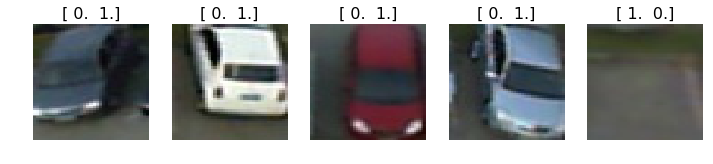

In [15]:
#sample batch data
batch_size = 5
batches = get_batches(path+'train', batch_size=batch_size)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [16]:
#predictions sample batch data
pred_batch(model,classes,imgs)

Shape: (5, 2)
Classes: ['empty', 'occupied']
Probabilities: [ 0.2915  0.7085]

Predictions prob/class: 
  0.7085/occupied
  0.8645/occupied
  0.7029/occupied
  0.8970/occupied
  0.6056/empty


In [17]:
#finding predictions for sample test data
#Note: this takes average time = no of test images*0.01secs
start_time = time.time()
print(start_time)
#get the test batches and remove class label
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)
#generate the probobailty of belonging to a class
val_batches, probs = test_batches, model.predict_generator(test_batches, int(np.ceil(test_batches.samples/batch_size)))
print((time.time() - start_time),'s')

1509272875.4473917
Found 40 images belonging to 2 classes.
0.6935391426086426 s


In [18]:
print("time per image" , ((time.time() - start_time)/len(probs)))

time per image 0.017474478483200072


[[20  0]
 [ 3 17]]
error:  7.5


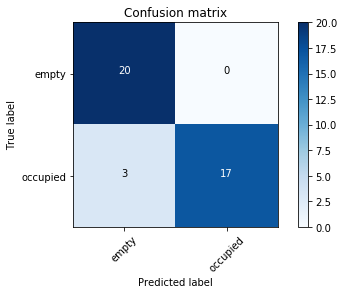

In [19]:
#computing confustion matrix

our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

expected_labels = val_batches.classes

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [20]:
model.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 3, 230, 230)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 64, 112, 112)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 64, 112, 112)  256         conv1[0][0]                      
___________________________________________________________________________________________

res3a_branch2a (Conv2D)          (None, 128, 28, 28)   32896       activation_10[0][0]              
____________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizatio (None, 128, 28, 28)   512         res3a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_11 (Activation)       (None, 128, 28, 28)   0           bn3a_branch2a[0][0]              
____________________________________________________________________________________________________
res3a_branch2b (Conv2D)          (None, 128, 28, 28)   147584      activation_11[0][0]              
____________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizatio (None, 128, 28, 28)   512         res3a_branch2b[0][0]             
___________________________________________________________________________________________

bn4a_branch2b (BatchNormalizatio (None, 256, 14, 14)   1024        res4a_branch2b[0][0]             
____________________________________________________________________________________________________
activation_24 (Activation)       (None, 256, 14, 14)   0           bn4a_branch2b[0][0]              
____________________________________________________________________________________________________
res4a_branch2c (Conv2D)          (None, 1024, 14, 14)  263168      activation_24[0][0]              
____________________________________________________________________________________________________
res4a_branch1 (Conv2D)           (None, 1024, 14, 14)  525312      activation_22[0][0]              
____________________________________________________________________________________________________
bn4a_branch2c (BatchNormalizatio (None, 1024, 14, 14)  4096        res4a_branch2c[0][0]             
___________________________________________________________________________________________

bn4e_branch2a (BatchNormalizatio (None, 256, 14, 14)   1024        res4e_branch2a[0][0]             
____________________________________________________________________________________________________
activation_35 (Activation)       (None, 256, 14, 14)   0           bn4e_branch2a[0][0]              
____________________________________________________________________________________________________
res4e_branch2b (Conv2D)          (None, 256, 14, 14)   590080      activation_35[0][0]              
____________________________________________________________________________________________________
bn4e_branch2b (BatchNormalizatio (None, 256, 14, 14)   1024        res4e_branch2b[0][0]             
____________________________________________________________________________________________________
activation_36 (Activation)       (None, 256, 14, 14)   0           bn4e_branch2b[0][0]              
___________________________________________________________________________________________

bn5c_branch2a (BatchNormalizatio (None, 512, 7, 7)     2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_47 (Activation)       (None, 512, 7, 7)     0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Conv2D)          (None, 512, 7, 7)     2359808     activation_47[0][0]              
____________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizatio (None, 512, 7, 7)     2048        res5c_branch2b[0][0]             
____________________________________________________________________________________________________
activation_48 (Activation)       (None, 512, 7, 7)     0           bn5c_branch2b[0][0]              
___________________________________________________________________________________________

In [21]:
#code to beep when code ends
"""
import winsound
frequency = 200  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
"""

'\nimport winsound\nfrequency = 200  # Set Frequency To 2500 Hertz\nduration = 500  # Set Duration To 1000 ms == 1 second\nwinsound.Beep(frequency, duration)\n'

In [22]:
# -*- coding: utf-8 -*-
# Reference:
"""
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
François Chollet, https://github.com/fchollet/deep-learning-models
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-22-be0c2ff12473>, line 7)